In [2]:
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2
import get_data
import plotly.express as px
import sqlalchemy
from sqlalchemy import create_engine, text
import api_info

username = api_info.USERNAME
password = api_info.PASSWORD
host = api_info.HOST
port = api_info.PORT
db_name = api_info.DB_NAME
endpoint = 'postgresql://' + username + ':' + password + '@' + host + ':' + port + '/' + db_name
engine = sqlalchemy.create_engine(endpoint)

try:
    with engine.connect() as connection:
        print('success')

except Exception as e:
    print(e)

success


In [3]:
df = pd.DataFrame(engine.connect().execute(text('SELECT datadate,gvkey,tic,cusip,dlttq,lseq,seqq,ltq,actq,invtq,lctq,oiadpq,saleq FROM quarterly')))
#dlttq: total long term debt, 
#lseq: 
#ltq: Liabilities (Total)

# Debt to equity ratio = dlttq / seqq

In [4]:
df.head()

,datadate,gvkey,tic,cusip,dlttq,lseq,seqq,ltq,actq,invtq,lctq,oiadpq,saleq
0,2022-06-30,287462,FF,36116M106,None,337.3860,262.8060,74.5800,252.8430,31.5840,60.8160,-1.5150,117.7960
1,2022-09-30,287462,FF,36116M106,None,341.3380,278.5760,62.7620,257.7210,17.4000,48.6300,16.8900,118.1410
2,2022-12-31,287462,FF,36116M106,0.4350,355.9690,283.0000,72.9690,273.7760,26.7610,56.0980,11.7780,117.8160
3,2023-03-31,287462,FF,36116M106,None,373.2780,304.0980,69.1800,291.4980,69.2340,53.5810,18.2510,74.1810
4,2023-06-30,287462,FF,36116M106,None,354.4590,294.2230,60.2360,274.2730,67.3620,44.7880,-11.5830,85.3080


In [5]:
df = df.query('seqq != 0 & dlttq > 0 & actq > 0 & invtq > 0 & lctq > 0 & oiadpq > 0 & saleq > 0')
df['debt_to_equity'] = df['dlttq'] / df['seqq']
df['quick_ratio'] = (df['actq'] - df['invtq']) / df['lctq']
df['op_margin'] = df['oiadpq'] / df['saleq']
df.head()
df.head()

,datadate,gvkey,tic,cusip,dlttq,lseq,seqq,ltq,actq,invtq,lctq,oiadpq,saleq,debt_to_equity,quick_ratio,op_margin
2,2022-12-31,287462,FF,36116M106,0.4350,355.9690,283.0000,72.9690,273.7760,26.7610,56.0980,11.7780,117.8160,0.001537102473498233215547703180,4.403276409141145851902028593,0.09996944387859034426563454879
9,2017-12-31,288586,FLNG,G35947202,160.0000,684.5100,520.1010,164.4090,17.5700,1.0410,4.4090,1.2430,7.8600,0.3076325559843184304586993680,3.748922658199138126559310501,0.1581424936386768447837150127
10,2018-03-31,288586,FLNG,G35947202,270.0000,794.2420,518.3550,275.8870,49.2590,2.3600,5.8870,0.0370,15.0530,0.5208785484851115548224672281,7.966536436215389842024800408,0.002457981797648309307114860825
11,2018-06-30,288586,FLNG,G35947202,467.9950,1008.7310,515.5000,493.2310,81.7190,2.6150,25.2360,0.2570,7.0470,0.9078467507274490785645004850,3.134569662387066096053257252,0.03646941961118206328934298283
12,2018-09-30,288586,FLNG,G35947202,437.4430,988.3760,516.7520,471.6240,21.9320,1.5080,34.1810,7.2320,19.0080,0.8465240579620398179397467257,0.5975249407565606623562798046,0.3804713804713804713804713805


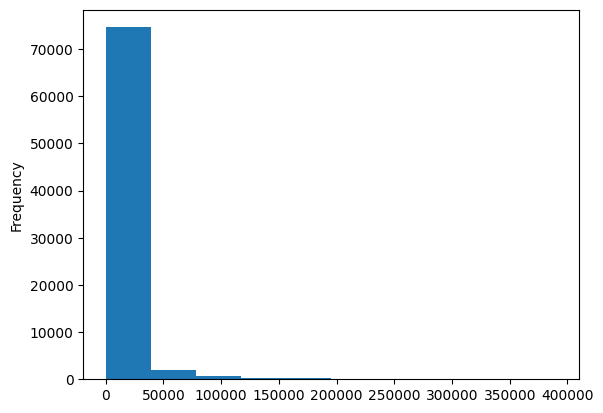

In [6]:
# print(max(df['debt_to_equity']), min(df['debt_to_equity']))

# Convert 'ltq' column to numeric data type
df['ltq'] = pd.to_numeric(df['ltq'], errors='coerce')

# Filter out rows with non-numeric values in 'ltq'
df = df[df['ltq'].notna()]

df['ltq'].plot(kind='hist')

# Filter out rows with negative values in dlttq, seqq, or 0
filtered_df = df[(df['dlttq'] > 0) & (df['seqq'] > 0)]

In [7]:
returns_df = pd.DataFrame(engine.connect().execute(text('SELECT date,cusip,ticker,ret,prc,askhi,bidlo FROM returns')))
returns_df.head()

,date,cusip,ticker,ret,prc,askhi,bidlo
0,2019-06-28,89623910,TRMB,0.015762,45.1100,45.2400,44.4900
1,2019-07-29,89623910,TRMB,-0.011376,44.3200,44.9600,44.2500
2,2019-07-30,89623910,TRMB,0.002708,44.4400,44.6300,43.8900
3,2019-07-31,89623910,TRMB,-0.049055,42.2600,44.9300,42.1300
4,2019-08-28,89623910,TRMB,0.008018,36.4600,36.7300,35.8600


11783960


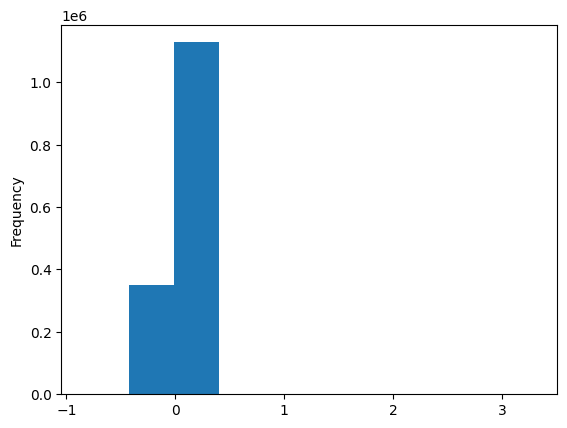

In [8]:
returns_df['ret'] = pd.to_numeric(returns_df['ret'], errors='coerce')
returns_df.dropna(subset=['ret'], inplace=True)
returns_df['ret'].plot(kind='hist')
returns_df['pct_change'] = returns_df['ret'].pct_change() / 100
returns_df['pct_change'] = scipy.stats.mstats.winsorize(returns_df['pct_change'], limits=[0.01, 0.01], axis=0, inplace=False, nan_policy='omit')
returns_df['pct_change'] = returns_df['pct_change'] + 1
returns_df.dropna(subset=['pct_change'], inplace=True)
returns_df.head()
print(returns_df.size)

In [9]:
returns_df['cum_return'] = returns_df.groupby('ticker')['pct_change'].cumprod()
print(returns_df.size)
returns_df.head()

13256955


,date,cusip,ticker,ret,prc,askhi,bidlo,pct_change,cum_return
1,2019-07-29,89623910,TRMB,-0.011376,44.3200,44.9600,44.2500,0.982783,0.982783
2,2019-07-30,89623910,TRMB,0.002708,44.4400,44.6300,43.8900,0.987620,0.970615
3,2019-07-31,89623910,TRMB,-0.049055,42.2600,44.9300,42.1300,0.808852,0.785084
4,2019-08-28,89623910,TRMB,0.008018,36.4600,36.7300,35.8600,0.988366,0.775950
5,2019-08-29,89623910,TRMB,0.029073,37.5200,37.7050,37.0000,1.026260,0.796326


In [10]:
window = 90
returns_df = returns_df.drop_duplicates(subset=['date','ticker'], keep='first')
returns_df[f'rolling_ret_{window}'] = returns_df.groupby('ticker')['cum_return'].pct_change()
returns_df.head()

,date,cusip,ticker,ret,prc,askhi,bidlo,pct_change,cum_return,rolling_ret_90
1,2019-07-29,89623910,TRMB,-0.011376,44.3200,44.9600,44.2500,0.982783,0.982783,NaN
2,2019-07-30,89623910,TRMB,0.002708,44.4400,44.6300,43.8900,0.987620,0.970615,-0.012380
3,2019-07-31,89623910,TRMB,-0.049055,42.2600,44.9300,42.1300,0.808852,0.785084,-0.191148
4,2019-08-28,89623910,TRMB,0.008018,36.4600,36.7300,35.8600,0.988366,0.775950,-0.011634
5,2019-08-29,89623910,TRMB,0.029073,37.5200,37.7050,37.0000,1.026260,0.796326,0.026260


In [11]:
print(returns_df[returns_df['ticker'] == 'FHTX'])

              date     cusip ticker       ret      prc    askhi    bidlo  \
195473  2020-10-28  34417410   FHTX -0.055000  15.1200  16.1500  14.0300   
195474  2020-10-29  34417410   FHTX  0.058201  16.0000  16.3900  15.0000   
195475  2020-10-30  34417410   FHTX -0.001250  15.9800  16.4500  15.0000   
195476  2020-11-30  34417410   FHTX -0.035800  20.2000  20.9700  18.7300   
195477  2020-12-28  34417410   FHTX -0.080390  22.6500  24.9300  22.3000   
...            ...       ...    ...       ...      ...      ...      ...   
195562  2023-11-28  34417410   FHTX -0.034483   4.2000   4.2900   4.1700   
195563  2023-11-29  34417410   FHTX -0.019048   4.1200   4.2800   4.0100   
195564  2023-11-30  34417410   FHTX  0.031553   4.2500   4.2600   4.0600   
195565  2023-12-28  34417410   FHTX  0.013493   6.7600   6.7700   6.5200   
195566  2023-12-29  34417410   FHTX -0.045858   6.4500   6.7900   6.3350   

        pct_change  cum_return  rolling_ret_90  
195473    1.004004    1.004004        

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# normalize signals
filtered_df[['debt_to_equity_norm', 'quick_ratio_norm', 'op_margin_norm']] = scaler.fit_transform(filtered_df[['debt_to_equity', 'quick_ratio', 'op_margin']])

# assign weights to each signal
weights = {'debt_to_equity': 0.4, 'quick_ratio': 0.3, 'op_margin': 0.3}

# Calculate the weighted sum of the normalized signals
filtered_df['weighted_sum'] = filtered_df['debt_to_equity_norm'] * weights['debt_to_equity'] + \
                              filtered_df['quick_ratio_norm'] * weights['quick_ratio'] + \
                              filtered_df['op_margin_norm'] * weights['op_margin']

# generate buy and sell signals based on the weighted sum
buy_trades, sell_trades = [], []
for d in filtered_df['datadate'].unique():
    temp = filtered_df[filtered_df['datadate'] == d]
    quntile_nbr = int(len(temp) / 5.0)


    buy_trades_combined = temp.sort_values('weighted_sum', ascending=False).head(quntile_nbr)
    buy_trades_combined['trade'] = 'buy'
    buy_trades_combined['signal'] = 'combined'

    sell_trades_combined = temp.sort_values('weighted_sum', ascending=True).head(quntile_nbr)
    sell_trades_combined['trade'] = 'sell'
    sell_trades_combined['signal'] = 'combined'

    buy_trades.append(buy_trades_combined)
    sell_trades.append(sell_trades_combined)

df_buy_trades = pd.concat(buy_trades)
df_sell_trades = pd.concat(sell_trades)

df_buy_trades = df_buy_trades.drop_duplicates(subset=['datadate', 'tic'], keep='first')
df_sell_trades = df_sell_trades.drop_duplicates(subset=['datadate', 'tic'], keep='first')

C:\Users\jeurc\AppData\Local\Temp\ipykernel_15432\1561665404.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[['debt_to_equity_norm', 'quick_ratio_norm', 'op_margin_norm']] = scaler.fit_transform(filtered_df[['debt_to_equity', 'quick_ratio', 'op_margin']])
C:\Users\jeurc\AppData\Local\Temp\ipykernel_15432\1561665404.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[['debt_to_equity_norm', 'quick_ratio_norm', 'op_margin_norm']] = scaler.fit_transform(filtered_df[['debt_to_equity'

<Axes: xlabel='datadate'>

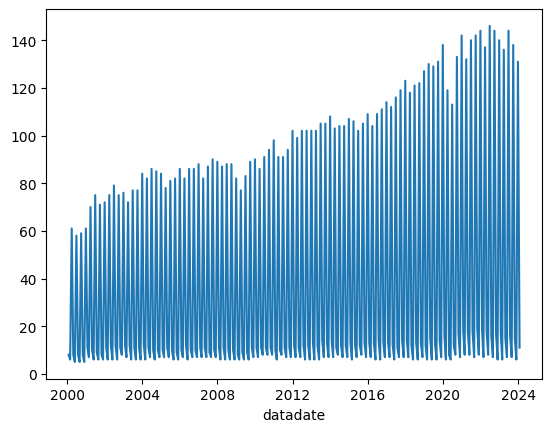

In [13]:
df_buy_trades.groupby('datadate')['tic'].size().plot(kind='line')

<Axes: xlabel='datadate'>

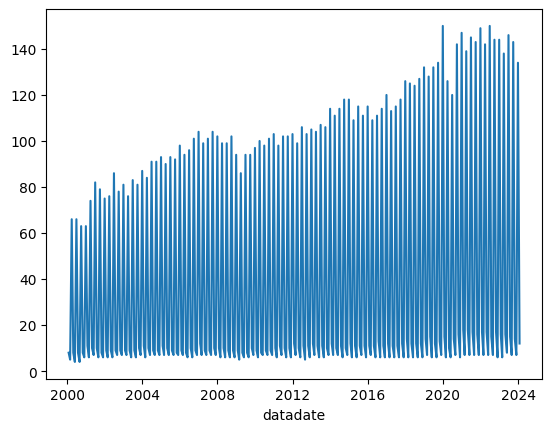

In [14]:
df_sell_trades.groupby('datadate')['cusip'].size().plot(kind='line')

In [15]:
returns_df['date'] = pd.to_datetime(returns_df['date'])
df_buy_trades['datadate'] = pd.to_datetime(df_buy_trades['datadate'])
df_sell_trades['datadate'] = pd.to_datetime(df_sell_trades['datadate'])

df_buy_trades = df_buy_trades.sort_values(by='datadate')
df_sell_trades = df_sell_trades.sort_values(by='datadate')
returns_df = returns_df.sort_values(by='date')

print(returns_df['ticker'].unique())

['RUSH' 'ATR' 'CW' ... 'TRML' 'VYX' 'BYON']


In [16]:
merged_buy_analysis = pd.merge(df_buy_trades, returns_df, left_on=['datadate', 'tic'], right_on=['date', 'ticker'], how='left')
merged_buy_analysis.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_buy_analysis = merged_buy_analysis.dropna(subset=['rolling_ret_90'])
print(merged_buy_analysis.tail())

merged_sell_analysis = pd.merge(df_sell_trades, returns_df, left_on=['datadate', 'tic'], right_on=['date', 'ticker'], how='left')
merged_sell_analysis.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_sell_analysis = merged_sell_analysis.dropna(subset=['rolling_ret_90'])
print(merged_sell_analysis.tail())

# Concatenate buy and sell trades
all_trades = pd.concat([merged_buy_analysis, merged_sell_analysis])
all_trades.reset_index(drop=True, inplace=True)
all_trades['rolling_ret_90'] = all_trades['rolling_ret_90'].clip(lower=-1, upper=1)

        datadate   gvkey    tic    cusip_x       dlttq         lseq  \
11166 2023-06-30  160329  GOOGL  02079K305  26451.0000  383044.0000   
11173 2023-06-30  027823   AORT  228903100    349.5440     777.8610   
11177 2023-06-30  026147    PEN  70975L107    218.5770    1432.5320   
11196 2023-08-31  001706   EPAC  292765104    239.5820     762.5970   
11361 2023-11-30  001706   EPAC  292765104    240.1280     765.5670   

              seqq         ltq         actq      invtq  ...       date  \
11166  267141.0000  115903.000  168788.0000  2231.0000  ... 2023-06-30   
11173     282.5080     495.353     263.8980    78.4580  ... 2023-06-30   
11177    1066.5430     365.989     827.8760   358.7700  ... 2023-06-30   
11196     326.6200     435.977     355.6400    74.7650  ... 2023-08-31   
11361     321.6760     443.891     359.9590    80.0810  ... 2023-11-30   

        cusip_y ticker       ret       prc     askhi     bidlo  pct_change  \
11166  02079K30  GOOGL  0.005038  119.7000  121.08

In [17]:
all_trades = pd.concat([merged_buy_analysis, merged_sell_analysis])
all_trades.reset_index(drop=True, inplace=True)
all_trades['rolling_ret_90'] = all_trades['rolling_ret_90'].clip(lower=-1, upper=1)

In [18]:
fig = px.box(all_trades, x='trade', y='rolling_ret_90')
fig.show()

In [19]:
returns_df['pct_change_shift_neg1'] = returns_df.groupby('ticker')['pct_change'].shift(-1)
reduced_returns_df = returns_df[['date', 'ticker', 'pct_change_shift_neg1']]
reduced_returns_df.dropna(inplace=True)
print(reduced_returns_df.tail())

             date ticker  pct_change_shift_neg1
298212 2023-12-28   CPSS               1.118644
821466 2023-12-28   SPHR               0.982349
676961 2023-12-28   CHRW               0.823217
880060 2023-12-28   MGEE               0.992340
671431 2023-12-28   EGHT               0.981077


C:\Users\jeurc\AppData\Local\Temp\ipykernel_15432\1444957922.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [20]:
all_trades_analysis = pd.concat([df_buy_trades, df_sell_trades])

# Creating 'trade_dir' column based on the 'trade' column
all_trades_analysis['trade_dir'] = np.where(all_trades_analysis['trade'] == 'buy', 1, -1)

# Printing the head of all_trades_analysis
print(all_trades_analysis.head())

         datadate   gvkey   tic      cusip     dlttq       lseq       seqq  \
115122 2000-01-31  001704  AMAT  038222105  585.0970  7057.9990  4756.5460   
51799  2000-01-31  009599  SMTC  816850101    0.0360   149.3500   125.4820   
114624 2000-01-31  001632   ADI  032654105   13.2180  2489.3330  1746.3450   
161762 2000-01-31  005338   GEF  397624107  253.0000   918.5100   505.8700   
75973  2000-01-31  117768  NVDA  67066G104    0.9620   202.2500   124.5630   

             ltq       actq     invtq  ...                     debt_to_equity  \
115122  2301.453  5462.5280  683.3780  ...     0.1230087967193000971713508079   
51799     23.868   120.4240   26.5810  ...  0.0002868937377472466170446757304   
114624   742.988  1558.9610  250.1840  ...   0.007568951152263727957534164212   
161762   412.640   220.5770   41.7320  ...     0.5001284915096763990748611303   
75973     77.687   173.1750   37.6310  ...   0.007722999606624760161524690317   

                          quick_ratio       

In [21]:
reduced_returns_df = reduced_returns_df.sort_values(by='date')
all_trades_analysis = all_trades_analysis.sort_values(by='datadate')
trade_df = pd.merge(all_trades_analysis, reduced_returns_df, how="left", left_on=["datadate", "tic"], right_on=["date","ticker"])
trade_df.dropna(inplace=True)
print(trade_df)

        datadate   gvkey   tic      cusip       dlttq        lseq        seqq  \
0     2000-01-31  001704  AMAT  038222105    585.0970   7057.9990   4756.5460   
2     2000-01-31  003570  CBRL  22410J106    329.5000   1291.9990    811.2720   
4     2000-01-31  002807  CASY  147528103    114.6520    635.2170    319.5590   
5     2000-01-31  027938  SCVL  824889109     22.3380    162.8530     93.3450   
6     2000-01-31  111873    RH  74967X103     37.7910    222.3610     82.8820   
...          ...     ...   ...        ...         ...         ...         ...   
23212 2023-11-30  065343  PSMT  741511109    220.4150   2029.2790   1082.2440   
23213 2023-11-30  025645   ACI  013091103  13311.1000  26496.5000   2527.3000   
23214 2023-11-30  011264   WBA  931427108  30624.0000  97823.0000  19481.0000   
23215 2023-11-30  004390   EBF  293389102      6.1400    401.2100    347.6270   
23216 2023-11-30  008348   PKE  70014A104      0.0940    127.5070    111.9850   

             ltq        act

In [22]:
trade_df.head()

,datadate,gvkey,tic,cusip,dlttq,lseq,seqq,ltq,actq,invtq,...,debt_to_equity_norm,quick_ratio_norm,op_margin_norm,weighted_sum,trade,signal,trade_dir,date,ticker,pct_change_shift_neg1
0,2000-01-31,001704,AMAT,038222105,585.0970,7057.9990,4756.5460,2301.453,5462.5280,683.3780,...,0.000027,0.098299,0.036742,0.040523,buy,combined,1,2000-01-31,AMAT,0.994581
2,2000-01-31,003570,CBRL,22410J106,329.5000,1291.9990,811.2720,480.727,118.8440,91.7600,...,0.000088,0.008459,0.007944,0.004956,sell,combined,-1,2000-01-31,CBRL,0.988703
4,2000-01-31,002807,CASY,147528103,114.6520,635.2170,319.5590,315.658,95.3500,54.3370,...,0.000078,0.010591,0.003787,0.004345,sell,combined,-1,2000-01-31,CASY,0.978175
5,2000-01-31,027938,SCVL,824889109,22.3380,162.8530,93.3450,69.508,109.1430,104.7300,...,0.000052,0.004672,0.001921,0.001999,sell,combined,-1,2000-01-31,SCVL,0.993681
6,2000-01-31,111873,RH,74967X103,37.7910,222.3610,82.8820,139.479,104.6880,85.9020,...,0.000099,0.012071,0.009658,0.006558,sell,combined,-1,2000-01-31,RH,1.000477


    datadate   gvkey   tic      cusip     dlttq       lseq       seqq  \
0 2000-01-31  001704  AMAT  038222105  585.0970  7057.9990  4756.5460   
2 2000-01-31  003570  CBRL  22410J106  329.5000  1291.9990   811.2720   
4 2000-01-31  002807  CASY  147528103  114.6520   635.2170   319.5590   
5 2000-01-31  027938  SCVL  824889109   22.3380   162.8530    93.3450   
6 2000-01-31  111873    RH  74967X103   37.7910   222.3610    82.8820   

        ltq       actq     invtq  ... quick_ratio_norm op_margin_norm  \
0  2301.453  5462.5280  683.3780  ...         0.098299       0.036742   
2   480.727   118.8440   91.7600  ...         0.008459       0.007944   
4   315.658    95.3500   54.3370  ...         0.010591       0.003787   
5    69.508   109.1430  104.7300  ...         0.004672       0.001921   
6   139.479   104.6880   85.9020  ...         0.012071       0.009658   

  weighted_sum trade    signal trade_dir       date  ticker  \
0     0.040523   buy  combined         1 2000-01-31    AMAT

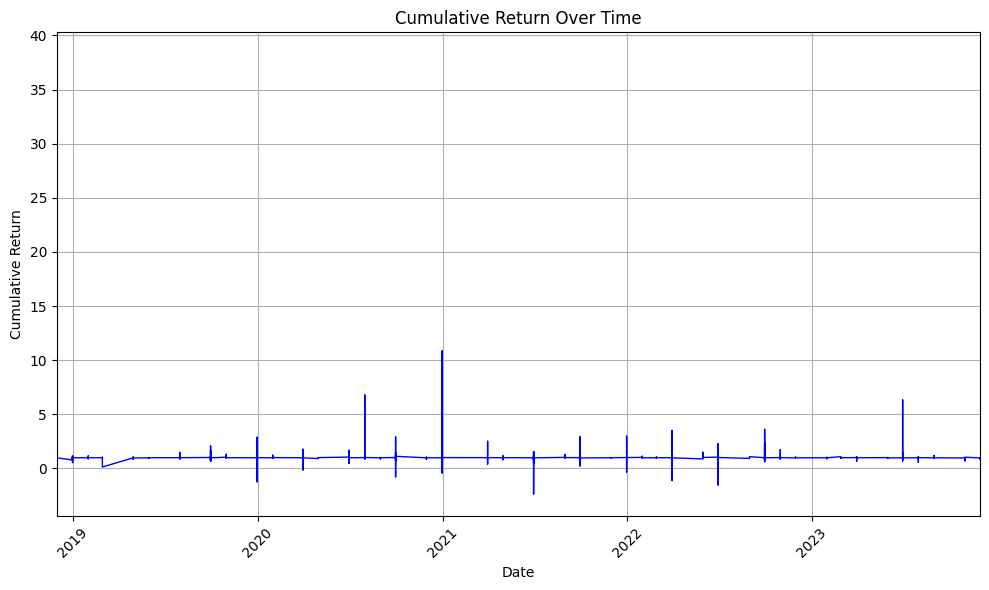

In [24]:
trade_df['cumulative_return'] = (1 + trade_df['pct_change_shift_neg1']).cumprod()
print(trade_df.head())

print(type(trade_df['date'][0]))
print(trade_df['date'].max())
plt.figure(figsize=(10, 6))
plt.plot(trade_df['date'], trade_df['pct_change_shift_neg1'], color='blue', linestyle='-', linewidth=1)
# filter to past 5 years
plt.xlim([trade_df['date'].max() - pd.DateOffset(years=5), trade_df['date'].max()])

# make plot green for positive return and red for negative

plt.title('Cumulative Return Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

         datadate   gvkey   tic      cusip     dlttq       lseq       seqq  \
115122 2000-01-31  001704  AMAT  038222105  585.0970  7057.9990  4756.5460   
51799  2000-01-31  009599  SMTC  816850101    0.0360   149.3500   125.4820   
114624 2000-01-31  001632   ADI  032654105   13.2180  2489.3330  1746.3450   
161762 2000-01-31  005338   GEF  397624107  253.0000   918.5100   505.8700   
75973  2000-01-31  117768  NVDA  67066G104    0.9620   202.2500   124.5630   

             ltq       actq     invtq  ...                     debt_to_equity  \
115122  2301.453  5462.5280  683.3780  ...     0.1230087967193000971713508079   
51799     23.868   120.4240   26.5810  ...  0.0002868937377472466170446757304   
114624   742.988  1558.9610  250.1840  ...   0.007568951152263727957534164212   
161762   412.640   220.5770   41.7320  ...     0.5001284915096763990748611303   
75973     77.687   173.1750   37.6310  ...   0.007722999606624760161524690317   

                          quick_ratio       

C:\Users\jeurc\AppData\Local\Temp\ipykernel_15432\3361662107.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             date ticker  pct_change_shift_neg1
298212 2023-12-28   CPSS               1.118644
821466 2023-12-28   SPHR               0.982349
676961 2023-12-28   CHRW               0.823217
880060 2023-12-28   MGEE               0.992340
671431 2023-12-28   EGHT               0.981077
    datadate   gvkey   tic      cusip     dlttq       lseq       seqq  \
0 2000-01-31  001704  AMAT  038222105  585.0970  7057.9990  4756.5460   
2 2000-01-31  003570  CBRL  22410J106  329.5000  1291.9990   811.2720   
4 2000-01-31  002807  CASY  147528103  114.6520   635.2170   319.5590   
5 2000-01-31  027938  SCVL  824889109   22.3380   162.8530    93.3450   
6 2000-01-31  111873    RH  74967X103   37.7910   222.3610    82.8820   

        ltq       actq     invtq  ... op_margin_norm weighted_sum trade  \
0  2301.453  5462.5280  683.3780  ...       0.036742     0.040523   buy   
2   480.727   118.8440   91.7600  ...       0.007944     0.004956  sell   
4   315.658    95.3500   54.3370  ...       0.00

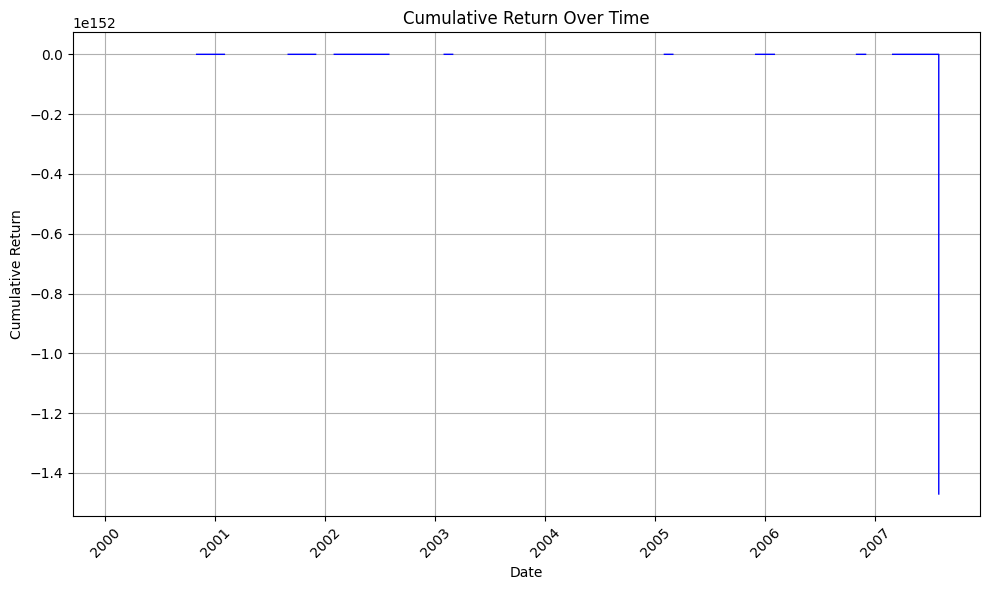

In [26]:
# 4.2.1 Create a trades data frame
all_trades_analysis = pd.concat([df_buy_trades, df_sell_trades])
all_trades_analysis['trade_dir'] = np.where(all_trades_analysis['trade'] == 'buy', 1, -1)
print(all_trades_analysis.head())

# 4.2.2 Prepare return series again, no look-ahead bias
returns_df['pct_change_shift_neg1'] = returns_df.groupby('ticker')['pct_change'].shift(-1)
reduced_returns_df = returns_df[['date', 'ticker', 'pct_change_shift_neg1']]
reduced_returns_df.dropna(inplace=True)
print(reduced_returns_df.tail())

# 4.2.3 Portfolio return
reduced_returns_df = reduced_returns_df.sort_values(by='date')
all_trades_analysis = all_trades_analysis.sort_values(by='datadate')
trade_df = pd.merge(all_trades_analysis, reduced_returns_df, how="left", left_on=["datadate", "tic"], right_on=["date", "ticker"])
trade_df.dropna(inplace=True)
trade_df['port_ret'] = trade_df['pct_change_shift_neg1'] * trade_df['trade_dir']
trade_df['port_ret'] = trade_df.groupby(['datadate'])['port_ret'].transform('sum')
trade_df['cumulative_return'] = (1 + trade_df['port_ret']).cumprod()
print(trade_df.head())

# Portfolio return plot
plt.figure(figsize=(10, 6))
plt.plot(trade_df['datadate'], trade_df['cumulative_return'], color='blue', linestyle='-', linewidth=1)
# plt.xlim([trade_df['datadate'].max() - pd.DateOffset(years=5), trade_df['datadate'].max()])
plt.title('Cumulative Return Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()